In [2]:
!pip install tushare

     |████████████████████████████████| 130 kB 7.8 MB/s 
     |████████████████████████████████| 130 kB 44.8 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 


In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tushare as ts
from statsmodels.tsa.arima_model import ARMA 
import scipy as stats 
from scipy import stats
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools as sm
import scipy.stats as scs
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Test before Arima 

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
(-2.633507306242954, 0.08626782555634072, 0, 587, {'1%': -3.4415393130846725, '5%': -2.866476335860869, '10%': -2.5693989358590006}, 174.19149801158323)
(-24.613252910426258, 0.0, 0, 586, {'1%': -3.4415584920942424, '5%': -2.866484781324317, '10%': -2.569403436033035}, 176.4810118331227)
difference order= 1


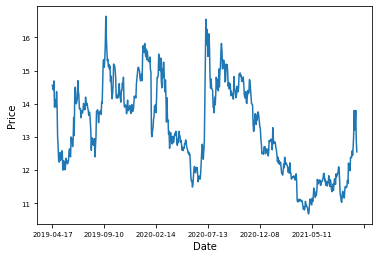

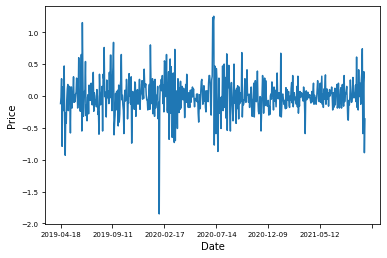

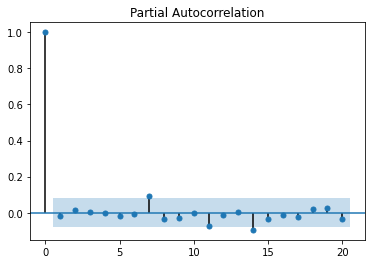

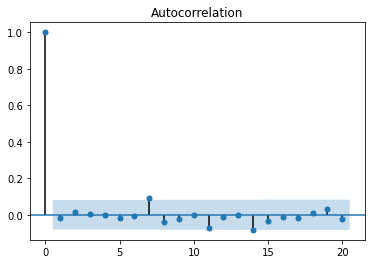

In [ ]:
def test_for_arima (stock_code):
  #load data of open
  hist=ts.get_hist_data(stock_code,start='2019-04-17',end='2021-09-10')
  hist=hist.sort_index()
  open=hist['open']
  open_original=open
  plt.figure()
  open.plot()
  plt.tick_params(axis='both',which='major',labelsize=7)
  plt.xlabel('Date',fontsize=10)
  plt.ylabel('Price',fontsize=10)
  plt.savefig("History Open Data of Stock '600036'.png")

  #Difference
  order=0
  #Apply ADF test
  print(sm.adfuller(open))
  while sm.adfuller(open)[1] > 0.01:
    open=open.diff(1).dropna()
    order = order+1
    print(sm.adfuller(open))

  print("difference order=",order)

  plt.figure()
  open.plot()
  plt.tick_params(axis='both',which='major',labelsize=7)
  plt.xlabel('Date',fontsize=10)
  plt.ylabel('Price',fontsize=10)
  plt.savefig("History Open Data of Stock '600837' after 1 order Difference'.png")


  # partial correlation
  plot_pacf(open,use_vlines=True,lags=20)
  
  # auto correlation
  plot_acf(open,use_vlines=True,lags=20)
  

  return open_original, open, order

open_original, open_diff, diff_order = test_for_arima ('600837')

Apply Arima

In [ ]:
from itertools import product
ps = range(3, 4)
qs = range(3, 4)
d = diff_order
parameters = product(ps, qs)
parameters_list = list(parameters)

from statsmodels.tsa.arima_model import ARIMA
best_bic = float('inf')
results = []
# pacf,acf:'tuowei', so use arma
for param in parameters_list:
    model = ARIMA(open_original,order=(param[0],1,param[1])).fit(disp=-1)
    bic = model.bic
    if bic < best_bic:
        best_model = model
        best_bic = model.bic
        best_param = param
    results.append([param, model.bic])
results_table = pd.DataFrame(results)
results_table.columns = ['parameters', 'bic']
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

                             ARIMA Model Results                              
Dep. Variable:                 D.open   No. Observations:                  587
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -90.875
Method:                       css-mle   S.D. of innovations              0.282
Date:                Sat, 16 Oct 2021   AIC                            197.750
Time:                        07:38:19   BIC                            232.750
Sample:                             1   HQIC                           211.388
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0040      0.002     -2.055      0.040      -0.008      -0.000
ar.L1.D.open    -0.2138      0.118     -1.814      0.070      -0.445       0.017
ar.L2.D.open     0.2699      0.108      2.50

Test after Arima

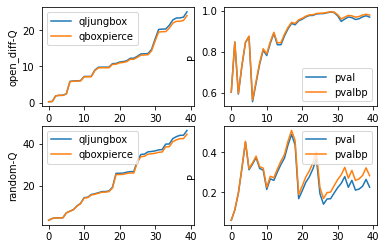

In [ ]:
# White-noise test (ljungbox)
from statsmodels.stats.diagnostic import acorr_ljungbox
import random 
qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(best_model.resid, boxpierce=True)
fig, axes = plt.subplots(2,2)
axes[0,0].plot(qljungbox, label='qljungbox');axes[0,0].set_ylabel('open_diff-Q')
axes[0,0].plot(qboxpierce, label='qboxpierce')

axes[0,1].plot(pval, label='pval');axes[0,1].set_ylabel('P')
axes[0,1].plot(pvalbp, label='pvalbp')

#random to compare
x=[random.randint(1, 200) for i in range(open_diff.shape[0])]
qljungbox, pval, qboxpierce, pvalbp=acorr_ljungbox(x, boxpierce=True)
axes[1,0].plot(qljungbox, label='qljungbox');axes[1,0].set_ylabel('random-Q')
axes[1,0].plot(qboxpierce, label='qboxpierce')

axes[1,1].plot(pval, label='pval');axes[1,1].set_ylabel('P')
axes[1,1].plot(pvalbp, label='pvalbp')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()

Prediction using Arima

0.2825935327437812


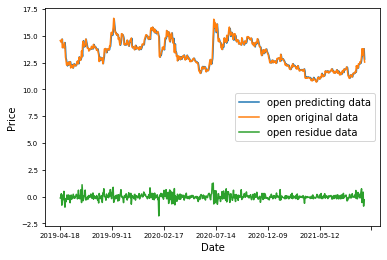

In [ ]:
## Check the accuracy of fitting
open_predict = best_model.predict(dynamic=False)
open_shift = open_original.shift(1)
open_recover = open_predict.add(open_shift) 
open_residue = best_model.resid


plt.figure()
open_recover.plot(label='open predicting data')
open_original.plot(label='open original data')
open_residue.plot(label='open residue data')
plt.tick_params(axis='both',which='major',labelsize=7)
plt.xlabel('Date',fontsize=10)
#plt.xticks(range(8)['2019/04/16','2019/09/09','2020/02/13','2020/07/10','2020/12/07','2021/05/10','2021/09/29'])
plt.ylabel('Price',fontsize=10)
plt.legend()
plt.savefig("History Prediction of '600036'.png")
rmse = np.sqrt(sum(pd.Series((open_recover-open_original)**2).dropna())/pd.Series((open_recover-open_original)**2).dropna().size)
print(rmse)

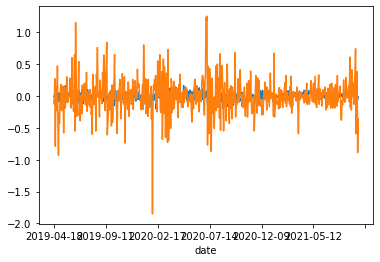

In [ ]:
open_predict.plot()
open_diff.plot()

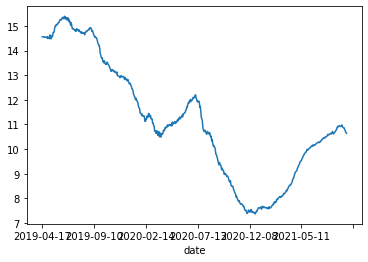

In [ ]:
predictions_diff = pd.Series(best_model.fittedvalues, copy=True)
predictions_diff_cumsum = predictions_diff.cumsum()
predictions_0 = pd.Series(open_original.iloc[0], index=open_original.index)
predictions_recover = predictions_0.add(predictions_diff_cumsum, fill_value=0)
predictions_recover.plot()

[12.50367997 12.55481259 12.48611101 12.4748333  12.50180551]
本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


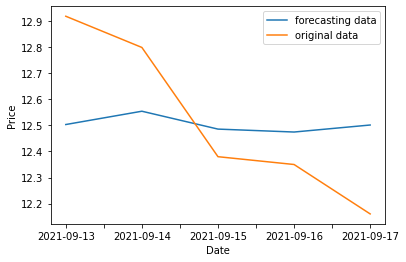

In [ ]:
forecast = best_model.forecast(steps=5)[0]
print(forecast)
pd.Series(forecast).plot(label='forecasting data')

#actual=ts.get_hist_data('600837',start='2021-09-13',end='2021-10-15')['open']
actual=ts.get_hist_data('600837',start='2021-09-13',end='2021-09-17')['open']
actual=actual.sort_index()
actual.plot(label='original data')
plt.xlabel('Date',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.legend()

## LSTM

In [5]:
def get_hist_data_lstm(stock_code, start_date='2019-04-01', end_date='2021-10-15'):

  hist = ts.get_hist_data(stock_code, start = start_date, end = end_date)

  return hist.sort_index()
  
hist = get_hist_data_lstm('600000')
hist

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
date,,,,,,,,,,,,,,
2019-06-26,11.56,11.73,11.66,11.55,369732.00,0.00,0.00,11.660,11.660,11.660,369732.00,369732.00,369732.00,0.13
2019-06-27,11.68,11.84,11.64,11.55,479977.84,-0.02,-0.17,11.650,11.650,11.650,424854.92,424854.92,424854.92,0.17
2019-06-28,11.67,11.68,11.68,11.54,295451.72,0.04,0.34,11.660,11.660,11.660,381720.52,381720.52,381720.52,0.11
2019-07-01,11.86,11.92,11.71,11.69,548878.81,0.03,0.26,11.673,11.673,11.673,423510.09,423510.09,423510.09,0.20
2019-07-02,11.72,11.74,11.61,11.57,511657.28,-0.10,-0.85,11.660,11.660,11.660,441139.53,441139.53,441139.53,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-11,9.12,9.25,9.15,9.10,466324.88,0.07,0.77,9.056,9.049,9.162,376504.64,374813.91,412995.79,0.16
2021-10-12,9.12,9.19,9.14,9.09,357257.50,-0.01,-0.11,9.078,9.052,9.157,381274.61,380306.14,405467.87,0.12
2021-10-13,9.14,9.15,9.07,9.05,225382.81,-0.07,-0.77,9.088,9.056,9.150,346334.64,367790.27,398923.14,0.08


### Standardization

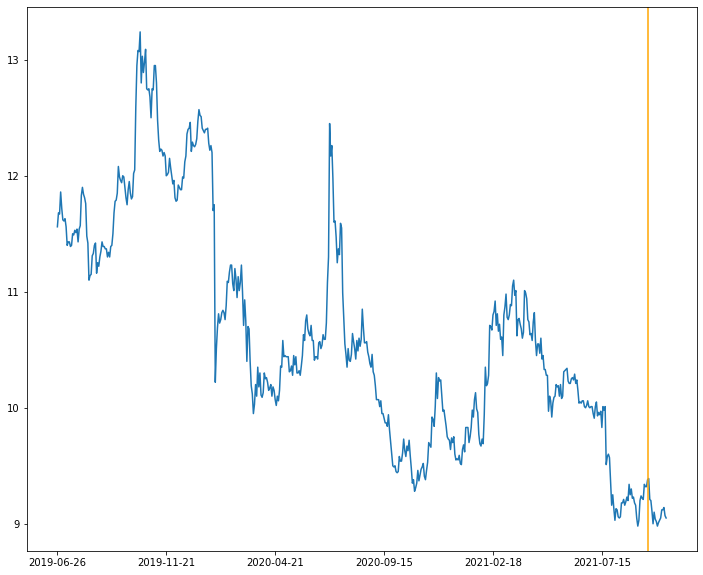

In [6]:
# from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MultipleLocator

def standardization_lstm(hist):

  ## opening price
  open_lstm = hist.open

  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(1,1,1)
  xmajorLocator = MultipleLocator(100)
  ax.xaxis.set_major_locator(xmajorLocator)
  plt.plot(open_lstm)

  plt.axvline(x='2021-09-13', color='orange')

  ## scaling
  open_lstm_std = (open_lstm - open_lstm.mean()) / open_lstm.std()

  ## reset index for 'date' column
  open_lstm_std = open_lstm_std.reset_index()

  # print(open_lstm.mean())
  # print(open_lstm.std())

  # print(open_lstm_std[-18:])

  return open_lstm.mean(), open_lstm.std(), open_lstm_std

mean, std, open_lstm_std = standardization_lstm(hist)

### sliding window train test split

In [7]:
## train test split

def train_test_split(open_lstm_std):

  train_set = open_lstm_std.iloc[:-18, 1] ## position where train data at 9.13
  test_set = open_lstm_std.iloc[-18:, 1]

  # print("train set length : ", train_set.shape[0])
  # print("test set length : ", test_set.shape[0])

  return train_set, test_set

train_set, test_set = train_test_split(open_lstm_std)

## create time lag/lookback (hyper-parameter)

def create_sliding(dataset, timelag):
  # print("time lag is : ", timelag)

  X = []
  y = []

  for i in range(dataset.shape[0]-timelag):
    X.append(dataset.iloc[i:(i+timelag)])
    y.append(dataset.iloc[i+timelag])

  X = np.array(X)
  y = np.array(y)

  X = X.reshape(X.shape[0], X.shape[1], 1)

  # print(X.shape)
  # print(y.shape)

  return X, y, timelag

X_train, y_train, timelag = create_sliding(train_set, 5)

# X_test, y_test, timelag = create_sliding(test_set, 30)
# print("")

# print(test_set)
# print(train_set[-20:])
# print(X_train)
open_lstm_std[-18:-13]


,date,open
542,2021-09-13,-1.252504
543,2021-09-14,-1.242466
544,2021-09-15,-1.423160
545,2021-09-16,-1.433198
546,2021-09-17,-1.523545


### test on different batch_size and epochs

Epoch 1/250
19/19 [==============================] - 8s 42ms/step - loss: 0.4933 - accuracy: 0.0000e+00
Epoch 2/250
19/19 [==============================] - 1s 43ms/step - loss: 0.1335 - accuracy: 0.0000e+00
Epoch 3/250
19/19 [==============================] - 1s 43ms/step - loss: 0.1043 - accuracy: 0.0000e+00
Epoch 4/250
19/19 [==============================] - 1s 43ms/step - loss: 0.0937 - accuracy: 0.0000e+00
Epoch 5/250
19/19 [==============================] - 1s 43ms/step - loss: 0.0899 - accuracy: 0.0000e+00
Epoch 6/250
19/19 [==============================] - 1s 43ms/step - loss: 0.0885 - accuracy: 0.0000e+00
Epoch 7/250
19/19 [==============================] - 1s 43ms/step - loss: 0.0896 - accuracy: 0.0000e+00
Epoch 8/250
19/19 [==============================] - 1s 43ms/step - loss: 0.0890 - accuracy: 0.0000e+00
Epoch 9/250
19/19 [==============================] - 1s 42ms/step - loss: 0.0794 - accuracy: 0.0000e+00
Epoch 10/250
19/19 [==============================] - 1s 42ms/st

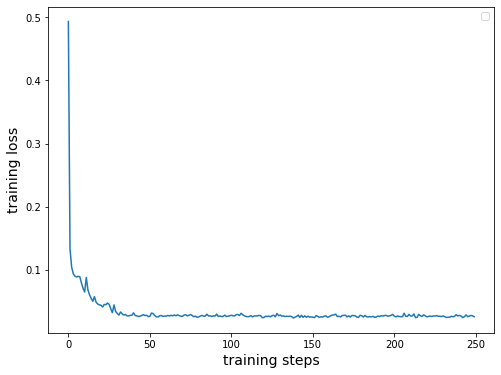

[-1.3478338, -1.3081622, -1.2850692, -1.2597665, -1.2330644]


NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, optimizers, Sequential

# batch_lst = [5, 8, 10, 12, 15, 20]
# epochs_lst = [150, 200, 250, 300]

count = 0
# fig = plt.figure(figsize=(28,16))

# for i in batch_lst:
#   for j in epochs_lst:
for i in range(3):
  
  model = Sequential()
  model.add(layers.LSTM(256, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(layers.LSTM(128, return_sequences=True))
  model.add(layers.LSTM(64, return_sequences=True))
  model.add(layers.LSTM(32))

  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(1))

  model.compile(optimizer=keras.optimizers.Adam(), loss='mse',metrics=['accuracy'])

  count += 1
  # print("the batch size is: ", i)
  # print("the epochs are: ", j)
  # ax = fig.add_subplot(7, 4, count)
  history = model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=250,
                      )

  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'])
  plt.xlabel("training steps", fontsize=14)
  plt.ylabel("training loss", fontsize=14)
  plt.legend()
  plt.show()

  # print("the batch size is: ", i)
  # print("the epochs are: ", j)
  # print("final training loss is: ", history.history['loss'][-1])

  # print("len of test_set: ", len(test_set))
  test_set_real = []

  y_pred = []

  timelag = 5

  pred_length = 5

  for k in range(5): ## how long prediction do we want

      num_extract = timelag - len(test_set_real) ## how many data we need to extract from the training set to generate the test set
      
      extra_fromtrain = np.append(train_set.values[-num_extract:], test_set_real).reshape(1, timelag, 1)

      # print(extra_fromtrain)
      
      test_set_real.append(model.predict(extra_fromtrain)[0][0])

      # print(test_set_real)


  # test_set_real = np.append(train_set.values[-1], test_set_real)


  # X_test_real, y_test_real, timelag = create_sliding(pd.Series(test_set_real), 7)


  ## prediction
  print(test_set_real[:])
  # print(open_lstm.std())

  pred = np.array(test_set_real) * open_lstm.std() + open_lstm.mean()
  real_val = test_set.values[0:5] * open_lstm.std() + open_lstm.mean()

  plt.figure(figsize=(8,6))
  plt.plot(pred, label='predictions')
  plt.plot(real_val, label='real values')
  plt.legend()
  xticks = [0, 1, 2, 3, 4]
  xticks_label = open_lstm_std.date[-18:-13].values
  plt.xlabel('Date',fontsize=14)
  plt.ylabel('Open Price',fontsize=14)
  plt.xticks(xticks, xticks_label)
  plt.show()
  mse = (pred - real_val) @ (pred - real_val) / len(pred)

  print("mean squared error is: ", mse)

### test on same structure with many times

Epoch 1/250
17/17 [==============================] - 10s 147ms/step - loss: 0.6073 - val_loss: 0.1404
Epoch 2/250
17/17 [==============================] - 1s 42ms/step - loss: 0.2408 - val_loss: 0.1181
Epoch 3/250
17/17 [==============================] - 1s 42ms/step - loss: 0.1983 - val_loss: 0.0995
Epoch 4/250
17/17 [==============================] - 1s 43ms/step - loss: 0.1729 - val_loss: 0.0925
Epoch 5/250
17/17 [==============================] - 1s 42ms/step - loss: 0.1614 - val_loss: 0.0915
Epoch 6/250
17/17 [==============================] - 1s 42ms/step - loss: 0.1505 - val_loss: 0.1012
Epoch 7/250
17/17 [==============================] - 1s 43ms/step - loss: 0.1364 - val_loss: 0.0725
Epoch 8/250
17/17 [==============================] - 1s 44ms/step - loss: 0.1308 - val_loss: 0.0833
Epoch 9/250
17/17 [==============================] - 1s 41ms/step - loss: 0.1217 - val_loss: 0.0660
Epoch 10/250
17/17 [==============================] - 1s 43ms/step - loss: 0.1295 - val_loss: 0.10

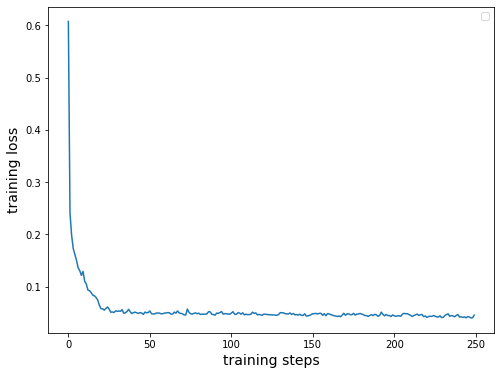

the batch size is:  20
the epochs are:  250
final training loss is:  0.0457179881632328


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, optimizers, Sequential


model = Sequential()
model.add(layers.LSTM(256, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))

model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mse')


# ax = fig.add_subplot(7, 4, count)
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=250,
                    validation_split=0.1
                    )

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.xlabel("training steps", fontsize=14)
plt.ylabel("training loss", fontsize=14)
plt.legend()
plt.show()

print("the batch size is: ", 20)
print("the epochs are: ", 250)
print("final training loss is: ", history.history['loss'][-1])



### test on different LSTM structure

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, optimizers, Sequential

def fit_lstm(X_train, y_train, batch_size=32, epochs=75):

  Input_shape = Input(shape=(np.array(X_train).shape[1],np.array(X_train).shape[2]))

  lstm1 = layers.LSTM(20,return_sequences=1)(Input_shape)
  print("lstm1:",lstm1.shape)

  lstm2 = layers.LSTM(64,return_sequences=0)(lstm1)
  print("lstm2:",lstm2.shape)

  dense1 = layers.Dense(64)(lstm2)
  print("dense:",dense1.shape)

  dropout = layers.Dropout(rate=0.2)(dense1)
  print("dropout:",dropout.shape)
  Output_shape = layers.Dense(1,activation="linear")(dropout)

  # Input_shape = Input(shape=(np.array(X_train).shape[1],np.array(X_train).shape[2]))

  # lstm1 = layers.LSTM(16,return_sequences=1)(Input_shape)
  # print("lstm1:",lstm1.shape)

  # lstm2 = layers.LSTM(32,return_sequences=1)(lstm1)
  # print("lstm2:",lstm2.shape)

  # lstm3 = layers.LSTM(16,return_sequences=0)(lstm2)
  # print("lstm3:",lstm3.shape)

  # # lstm4 = layers.Dense(32)(lstm3)
  # # print("lstm4:",lstm4.shape)

  # dropout = layers.Dropout(rate=0.2)(lstm3)
  # print("dropout:",dropout.shape)

  # Output_shape = layers.Dense(1,activation="linear")(dropout)

  lstm_model = tf.keras.Model(Input_shape,Output_shape)

  lstm_model.compile(loss="mean_squared_error",optimizer="Adam",metrics=["mse"]) # rmse as loss function，adam stochasic grandient descent as optimization

  history2 = lstm_model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=epochs, validation_split=0.1, verbose=1)

  lstm_model.summary()

  return lstm_model

In [ ]:
from keras.models import load_model

lstm_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del lstm_model  # deletes the existing model

# returns a compiled model
# identical to the previous one
lstm_model_load = load_model('my_model.h5')

In [9]:
def walk_forward(model, train_set, pred_length, timelag, mean, std):

  test_set_real = []


  for k in range(pred_length): ## how long prediction do we want

    if timelag > len(test_set_real):
      
      num_extract = timelag - len(test_set_real) ## how many data we need to extract from the training set to generate the test set
      
      extra_fromtrain = np.append(train_set.values[-num_extract:], test_set_real).reshape(1, timelag, 1)

      # print("prices used for training: ")
      # print(extra_fromtrain)
      # print("predicted value: ", lstm_model.predict(extra_fromtrain)[0][0])
      
      test_set_real.append(model.predict(extra_fromtrain)[0][0])

      
    else:
      
      extra_fromtest = np.array(test_set_real[-timelag:]).reshape(1, timelag, 1)

      # print("prices used for training: ")
      # print(extra_fromtest)
      # print("predicted value: ", lstm_model.predict(extra_fromtest)[0][0])

      test_set_real.append(model.predict(extra_fromtest)[0][0])


  ## prediction plot

  pred = np.array(test_set_real) * std + mean
  real_val = test_set.values[:] * std + mean

  fig = plt.figure(figsize=(16,6))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(pred[:5], label='predictions')
  ax1.plot(real_val[:5], label='real values')
  ax1.legend()
  xticks = [0, 1, 2, 3, 4]
  xticks_label = open_lstm_std.date[-18:-13].values
  plt.xlabel('Date',fontsize=14)
  plt.ylabel('Open Price',fontsize=14)
  plt.xticks(xticks, xticks_label)


  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(pred[:], label='predictions')
  ax2.plot(real_val[:], label='real values')
  plt.legend()
  xticks = [0, 6, 12, 18]
  xticks_label = open_lstm_std.date[-18::6].values
  plt.xlabel('Date',fontsize=14)
  plt.ylabel('Open Price',fontsize=14)
  plt.xticks(xticks, xticks_label)

  plt.show()
  rmse1 = np.sqrt((pred[:5] - real_val[:5]) @ (pred[:5] - real_val[:5]) / len(pred[:5]))

  rmse2 = np.sqrt((pred - real_val) @ (pred - real_val) / len(pred))

  print(" root mean squared error is: ", rmse1)
  print(" root mean squared error is: ", rmse2)

  return pred, real_val, rmse1, rmse2

# pred, real_val, rmse1, rmse2 = walk_forward(lstm_model, train_set, 18, 5, mean, std)

stock id is:  600837
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
(537, 5, 1)
lstm1: (None, 5, 20)
lstm2: (None, 64)
dense: (None, 64)
dropout: (None, 64)
Epoch 1/75
16/16 [==============================] - 5s 67ms/step - loss: 0.5319 - mse: 0.5319 - val_loss: 0.1332 - val_mse: 0.1332
Epoch 2/75
16/16 [==============================] - 0s 9ms/step - loss: 0.1615 - mse: 0.1615 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 3/75
16/16 [==============================] - 0s 9ms/step - loss: 0.1278 - mse: 0.1278 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 4/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.0746 - val_mse: 0.0746
Epoch 5/75
16/16 [==============================] - 0s 9ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 6/75
16/16 [==============================] - 0s 9ms/step - loss: 0.1107 - mse: 0.1107 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 7/75
16/16 [==============================] - 0s 

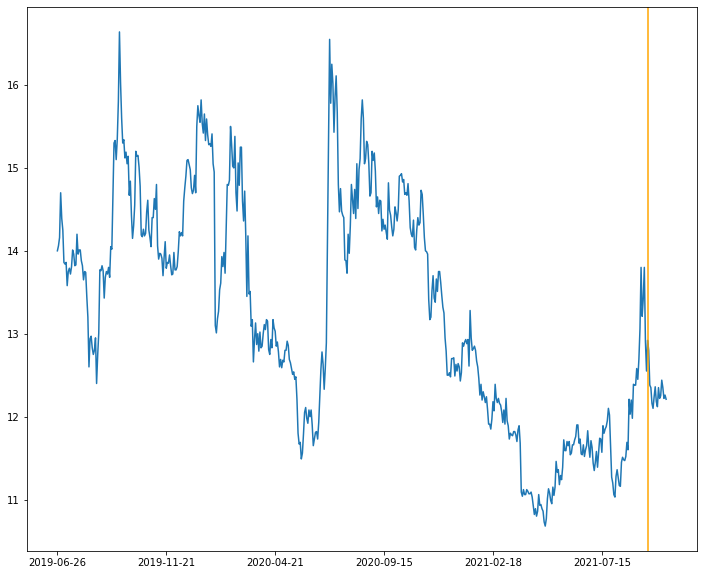

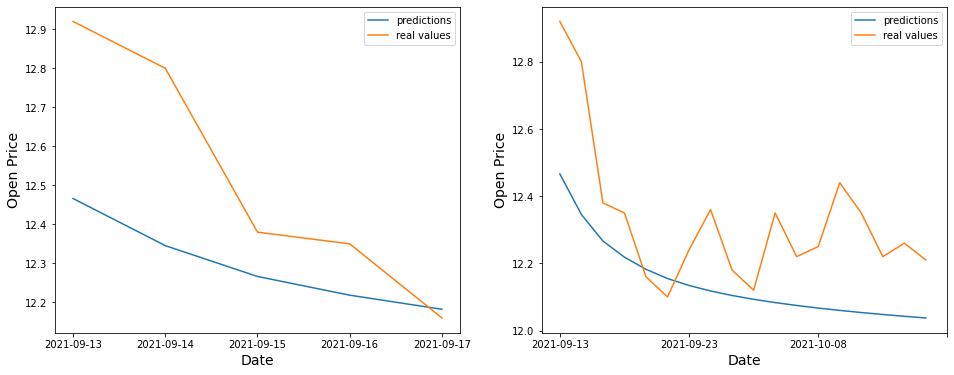

 root mean squared error is:  0.2977251067404345
 root mean squared error is:  0.23421685050937677
stock id is:  600837
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
(537, 5, 1)
lstm1: (None, 5, 20)
lstm2: (None, 64)
dense: (None, 64)
dropout: (None, 64)
Epoch 1/75
16/16 [==============================] - 4s 65ms/step - loss: 0.7030 - mse: 0.7030 - val_loss: 0.4231 - val_mse: 0.4231
Epoch 2/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1704 - mse: 0.1704 - val_loss: 0.1346 - val_mse: 0.1346
Epoch 3/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1343 - mse: 0.1343 - val_loss: 0.0817 - val_mse: 0.0817
Epoch 4/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1223 - mse: 0.1223 - val_loss: 0.0874 - val_mse: 0.0874
Epoch 5/75
16/16 [==============================] - 0s 9ms/step - loss: 0.1188 - mse: 0.1188 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 6/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1194 - ms

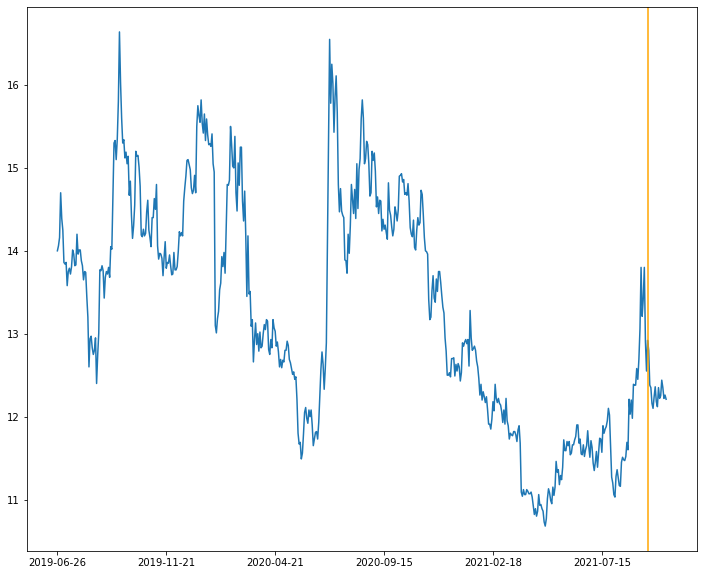

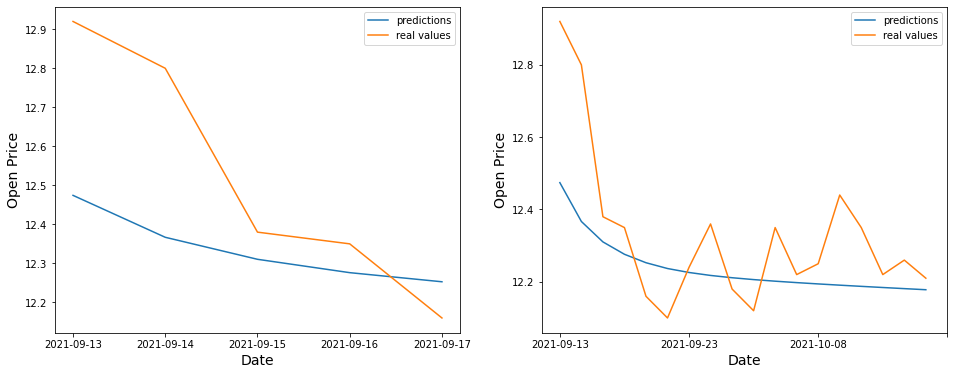

 root mean squared error is:  0.28469063334965705
 root mean squared error is:  0.17880455420626012
stock id is:  600837
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
(537, 5, 1)
lstm1: (None, 5, 20)
lstm2: (None, 64)
dense: (None, 64)
dropout: (None, 64)
Epoch 1/75
16/16 [==============================] - 5s 68ms/step - loss: 0.6638 - mse: 0.6638 - val_loss: 0.2193 - val_mse: 0.2193
Epoch 2/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1665 - mse: 0.1665 - val_loss: 0.1041 - val_mse: 0.1041
Epoch 3/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 4/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1213 - mse: 0.1213 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 5/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1221 - mse: 0.1221 - val_loss: 0.0712 - val_mse: 0.0712
Epoch 6/75
16/16 [==============================] - 0s 10ms/step - loss: 0.1194 - 

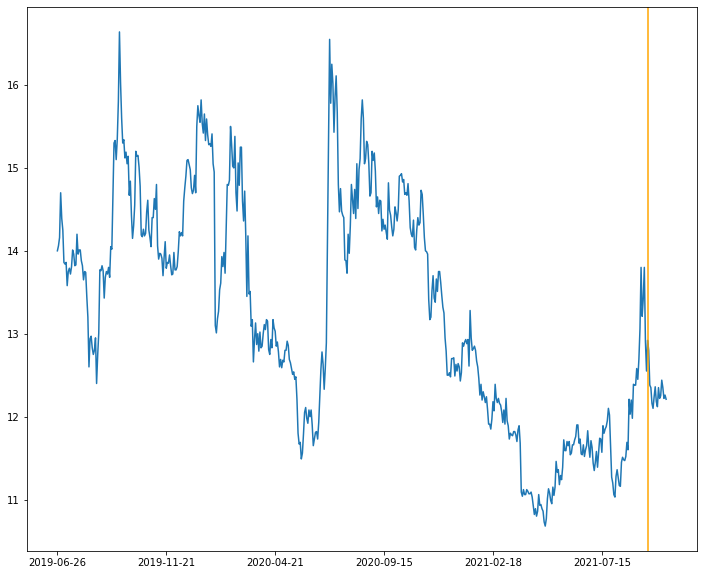

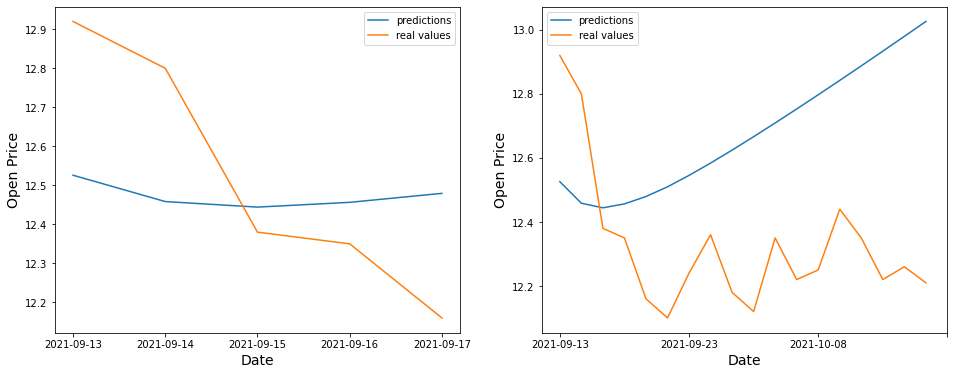

 root mean squared error is:  0.27910078377244363
 root mean squared error is:  0.4745434589118875


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, optimizers, Sequential

# stock_lst = ['600000', '600016', '600019', '600028', '600029', '600030', '600031', '600036', '600048',
#              '600050', '600104', '600196', '600276', '600309', '600340', '600519', '600585', '600690',
#              '600703', '600837', '600887', '601066', '601088', '601111', '601138', '601166', '601186',
#              '601211', '601229', '601288', '601318', '601319', '601328', '601336', '601390', '601398',
#              '601601', '601628', '601668', '601688', '601766', '601800', '601818', '601857', '601888',
#              '601939', '601988', '601989', '603259', '603993']

stock_test_lst = ['600837']
timelag = 5

keras.backend.clear_session()

for j in range(3):

  for i in stock_test_lst:

    keras.backend.clear_session()

    print("stock id is: ", i)

    ## load stock
    hist = get_hist_data_lstm(i)

    ## standardize open price
    mean, std, open_lstm_std = standardization_lstm(hist)

    ## train test split and sliding window
    train_set, test_set = train_test_split(open_lstm_std)
    X_train, y_train, timelag = create_sliding(train_set, timelag)
    print(X_train.shape)

    ## fit lstm
    lstm_model = fit_lstm(X_train, y_train)

    ## get prediction results
    pred, real_val, rmse1, rmse2 = walk_forward(lstm_model, train_set, 18, timelag, mean, std)
    
    keras.backend.clear_session()